In [25]:
import os 
import matplotlib.pyplot as plt
dir=os.getcwd()

# for path in os.listdir(dir):
#     if path.endswith('.log'):
#         f  = open(path, "r")
#         print(path)

f  = open("./P2_pid_6968.log", "r")
entries = []
logical_clocks = [] 
sys_clocks = []
events = [] 
codes = []

for log in f: 
    if log.startswith('RECEIVE MESSAGE'):
        log_lst = log.split(',')
        sys_clock = int(log_lst[2].replace('sys_clock: ', ''))
        logical_clock = int(log_lst[3].replace('logical_clock: ', ''))
        sys_clocks.append(sys_clock)
        logical_clocks.append(logical_clock)
        events.append('recv')
        codes.append('-1')
    elif log.startswith('INTERNAL EVENT'): 
        log_lst = log.split(',')
        sys_clock = int(log_lst[2].replace('sys_clock: ', ''))
        logical_clock = int(log_lst[3].replace('logical_clock: ', ''))
        sys_clocks.append(sys_clock)
        logical_clocks.append(logical_clock)
        events.append('internal')
        codes.append('3')
    elif log.startswith('SENT'):
        log_lst = log.split(',')
        sys_clock = int(log_lst[2].replace('sys_clock: ', ''))
        logical_clock = int(log_lst[3].replace('logical_clock: ', ''))
        sys_clocks.append(sys_clock)
        logical_clocks.append(logical_clock)
        code = log_lst[4]
        code_lst = code.split('')
        codes.append(len(code_lst))
        events.append('send')
    else:
        print(log)
        
        

Hello from process P2 with pid 6968 at rate 0.3333333333333333



ValueError: invalid literal for int() with base 10: ' sys_clock:12'

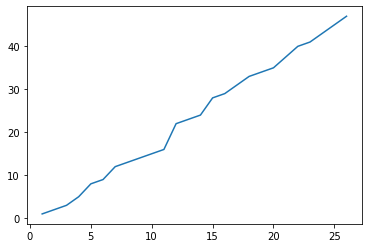

In [23]:
plt.plot(sys_clocks, logical_clocks)